## Model Evaluation and Hyperparameter Tuning 
In this segment we would learn about how to access our model that we trained initially and how to tune out hyperparameters so that we would get the best tuned model and hence would obtain the accuracy for the trained model.

### Preparing the Dataset
Here first we process the dataset so that it is made in the form that we could train the model on it and hence then evaluate our model and then tune the hyperparameters so that we could achieve best accuracy.

In [27]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
## Here we use the breast cancer wisconsin dataset to build out model and hence evaluate our models hyperparameters and hence tune them
df = pd.read_csv('wdbc.data',header = None)
X = df.loc[:,2:].values
y = df.loc[:,1].values
le = LabelEncoder()
y = le.fit_transform(y)      ## Label encoding the classes of the dataset and hence splitting the dataset
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,stratify = y,random_state = 1)

### Pipeline
Pipeline is one of the most useful classes built into sklearn in which we could process the given dataset through different layers of transformations and hence then use the estimator on it

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
## first using Standard Scaler to standardize the data, then PCA for feature extraction and then fitted the model to a Logistic Regression
pipe_lr = make_pipeline(StandardScaler(),PCA(n_components=2),LogisticRegression(random_state = 1))
pipe_lr.fit(X_train,y_train)
y_pred = pipe_lr.predict(X_test)
print('Test accuracy: %.3f' % pipe_lr.score(X_test,y_test))

Test accuracy: 0.956


### K-Fold Cross Validation
Here we would learn one of the most important methods of model evaluation by still keeping the bias-variance trade-off at check as using this method we divide our training dataset into distinct K sets(folds) and then train our model K times each time on K-1 different sets for training and the K-th set for testing this model or cross-validating and hence then take average of the Evaluations which we can generalize and take that as our accuracy of the model.

In [29]:
import numpy as np
from sklearn.model_selection import StratifiedKFold  ### Stratified k-folds ensure that the class labels have the same distribution in all the K-folds
kfold = StratifiedKFold(n_splits = 10).split(X_train,y_train) ## taking 10 folds for cross validation

scores = []
for k , (train,test) in enumerate(kfold):
    pipe_lr.fit(X_train[train],y_train[train])
    score = pipe_lr.score(X_train[test],y_train[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,np.bincount(y_train[train]),score))
print('\n CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores))) ## The average accuracy lies around this threshold

Fold:  1, Class dist.: [256 153], Acc: 0.935
Fold:  2, Class dist.: [256 153], Acc: 0.935
Fold:  3, Class dist.: [256 153], Acc: 0.957
Fold:  4, Class dist.: [256 153], Acc: 0.957
Fold:  5, Class dist.: [256 153], Acc: 0.935
Fold:  6, Class dist.: [257 153], Acc: 0.956
Fold:  7, Class dist.: [257 153], Acc: 0.978
Fold:  8, Class dist.: [257 153], Acc: 0.933
Fold:  9, Class dist.: [257 153], Acc: 0.956
Fold: 10, Class dist.: [257 153], Acc: 0.956

 CV accuracy: 0.950 +/- 0.014


In [30]:
## OR we could just directly use cross_val_score method that would evaluate the scores directly by just providing the required inputs
from sklearn.model_selection import cross_val_score
scores = cross_val_score(estimator = pipe_lr,X= X_train,y = y_train,cv = 10,n_jobs = 1)
print('CV accuracy scores : %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores),np.std(scores)))

CV accuracy scores : [0.93478261 0.93478261 0.95652174 0.95652174 0.93478261 0.95555556
 0.97777778 0.93333333 0.95555556 0.95555556]
CV accuracy: 0.950 +/- 0.014


## Learning Curves
Learning Curves are also important for model evaluation as these can point us towards the direction if our curves are facing more of bias error or variance error, by plotting these curves we could easily evaluate in which direction our model learning needs to go and hence we can implement as thus.Here we can verify our learning accuracy with the change in the training sizes.

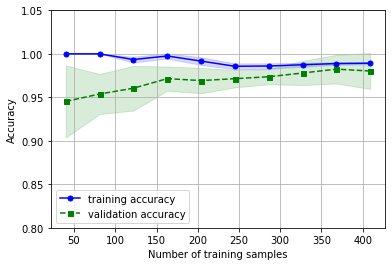

In [31]:
## importing the required libraries
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
## making the pipeline 
pipe_lr = make_pipeline(StandardScaler(),LogisticRegression(penalty = 'l2',random_state=1,max_iter=10000))

train_sizes, train_scores,test_scores = learning_curve(estimator = pipe_lr,X=X_train,y=y_train,train_sizes = np.linspace(0.1,1.0,10),cv = 10,n_jobs = 1)
train_mean = np.mean(train_scores,axis = 1)
train_std = np.std(train_scores,axis = 1)
test_mean = np.mean(test_scores,axis = 1)
test_std = np.std(test_scores,axis = 1)

plt.plot(train_sizes,train_mean,color = 'blue',marker = 'o',markersize = 5,label = 'training accuracy')

plt.fill_between(train_sizes,train_mean+train_std,train_mean-train_std,alpha = 0.15,color = 'blue')

plt.plot(train_sizes,test_mean,color = 'green',linestyle = '--',marker = 's',markersize = 5,label = 'validation accuracy')

plt.fill_between(train_sizes,test_mean + test_std,test_mean - test_std,alpha=0.15,color = 'green')

plt.grid()
plt.xlabel('Number of training samples')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower left')
plt.ylim([0.8,1.05])
plt.show()
## Hence we can check that with the amount of different training sizes we get our respective accuracies

## Validation Curves
Validation Curves are curves which allows us to verify our models bias and variance measure with respect to diffent hyperparameter and by checking these curves we can verify which values of hyperparameter would work best for our model.These curves are very usefull and we can tune a particular hyperparameter for better model accuracy but one downside with this method is that we have to keep all the other hyperparameters constant and change only one particular hyperparameter hence we need to iterate many times for different hyperparameters which can be time consuming.

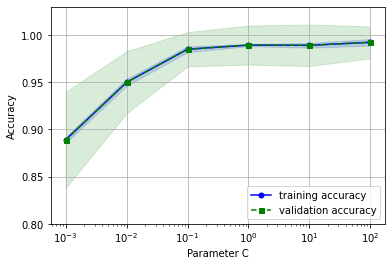

In [32]:
## Hence we can plot our model using validation curve and tune a particular hyperparameter as needed
from sklearn.model_selection import validation_curve
param_range = [0.001,0.01,0.1,1.0,10.0,100.0]
train_scores , test_scores = validation_curve(estimator = pipe_lr,X = X_train,y = y_train,param_name='logisticregression__C',param_range=param_range,cv = 10)
train_mean = np.mean(train_scores,axis = 1)
train_std = np.std(train_scores,axis = 1)
test_mean = np.mean(train_scores,axis = 1)
test_std = np.std(test_scores,axis = 1)
plt.plot(param_range,train_mean,color = 'blue',marker = 'o',markersize = 5,label='training accuracy')
plt.fill_between(param_range,train_mean+train_std,train_mean-train_std,alpha = 0.15,color = 'blue')
plt.plot(param_range,test_mean,color = 'green',linestyle='--',marker = 's',markersize = 5,label = 'validation accuracy')
plt.fill_between(param_range,test_mean+test_std,test_mean-test_std,alpha = 0.15,color = 'green')
plt.grid()
plt.xscale('log')
plt.legend(loc = 'lower right')
plt.xlabel('Parameter C')
plt.ylabel('Accuracy')
plt.ylim([0.8,1.03])
plt.show()
## Even though we have similar means but the validation accuracy has a larger variance as opposed to training accuracy

## Grid Search
Grid Search is a popular hyperparameter search algotrithm where we use the algorithm to run different sets of hyperparameters that we provide it and evaluates the best set of hyperparameters from these set thus enabling us to search for different hyperparameters in one go but the process that it runs is all brute force that is it uses all the provided sets of hyperparameters in every combination, runs them and hence evaluates them individually to give us the required accuracy score.Here we also combine the idea of K-fold CV inside evaluating a Grid Search to have better accuracy.

In [8]:
## Here we train a standard SVM using pipeline on the provided dataset to search for the best hyperparameter valeus in the provided ones
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

pipe_svc = make_pipeline(StandardScaler(),SVC(random_state = 1))
param_range = [0.0001,0.001,0.01,0.1,1.0,10.0,100.0,1000.0]
param_grid = [{'svc__C':param_range,
               'svc__kernel':['linear']},
              {'svc__C':param_range,
               'svc__gamma':param_range,
               'svc__kernel':['rbf']}]

gs = GridSearchCV(estimator = pipe_svc,param_grid = param_grid,
                 scoring = 'accuracy',cv = 10,n_jobs = -1)
gs = gs.fit(X_train,y_train)
print(gs.best_score_)              ## Checking the best score
print(gs.best_params_)             ## Checking what are the best hyperparameters
clf = gs.best_estimator_           ## getting a classifier based on the best hyperparameter values 
clf.fit(X_train,y_train)           ## Hence training it and evaluating it respectively
print('Test accuracy: %.3f ' % clf.score(X_test,y_test))
## Hence we get a good accuracy score

0.9846859903381642
{'svc__C': 100.0, 'svc__gamma': 0.001, 'svc__kernel': 'rbf'}
Test accuracy: 0.974 


## Nested CV
Using GridSearch CV we can find the best hyperparameter values which can be used for the required Machine Learning Model but when it comes to selecting a particular Machine Learning Model from different present we can use the idea of Nested CV as it ensures that the error of the estimate is almost unbiased relative to the test set and hence we can use different models to verify there accracy and hence use GridSearch CV on them for better Evaluations.

In [9]:
## Here we used two different models to train on the dataset and hence evaluate their accuracies to compare them
from sklearn.tree import DecisionTreeClassifier
gs = GridSearchCV(estimator = pipe_svc,param_grid = param_grid,scoring ='accuracy',cv = 2) ## Here we use nested cv in two ways by first creating the respective inner training and validation set
scores = cross_val_score(gs,X_train,y_train,scoring = 'accuracy',cv = 5)   ## Here we create the outer training and test sets 
print('CV accuracy: %.3f +/- %.3f' %(np.mean(scores),np.std(scores)))
gs = GridSearchCV(estimator = DecisionTreeClassifier(random_state=0),param_grid=[{'max_depth':[1,2,3,4,5,6,7,None]}],scoring = 'accuracy',cv = 2)
print('CV accuracy : %.3f +/- %.3f '%(np.mean(scores),np.std(scores)))
## Hence we can verify the accuracy of different models on the provided dataset

CV accuracy: 0.974 +/- 0.015
CV accuracy : 0.974 +/- 0.015 


## Evaluation Metrics
Evaluation is next step that comes after training a model and is really important concerning the fact that we check the respective accuracies of our model and fine tune them to build better models for deployment

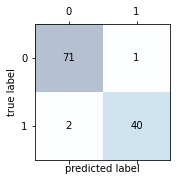

In [10]:
## here we ues the confusion_matrix for checking the acurracy of our classification model and verify which type of error we might be facing
from sklearn.metrics import confusion_matrix
pipe_svc.fit(X_train,y_train)       ## Here we fit out Standard SVM Model and check its accuracy and hence plot it
y_pred = pipe_svc.predict(X_test)
confmat = confusion_matrix(y_true = y_test,y_pred = y_pred)   ## Make out the confusion matrix
fig ,ax = plt.subplots(figsize = (2.5,2.5))                   ## Hence plotting it
ax.matshow(confmat,cmap = plt.cm.Blues,alpha = 0.3)
for i in range(confmat.shape[1]):
    for j in range(confmat.shape[0]):
        ax.text(x=j,y=i,s=confmat[i,j],va = 'center',ha = 'center')
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

### Scores of Classification
Here we define the respective scores for the total evaluation of Classification Algorithms.The Scores we define are Precision Score, Recall Score and F1 Score.
**Precision Score** : It is defined as the ratio of True Positives to the number of Positive Classes Classified.
**Recall Score** : It is defined as the ratio of True Positives to the number of Positive Classes Present.
**F1 Score** : It can be defined as a single number metric evaluation for classification algorithm and this combines both the Precision Score and Recall Score together to give a combined formula.

These three scores can be used in different situations depending upon the real problem that we deling with and handle the respective Type-1 and Type-2 error cases.

In [11]:
## Here we check the different scores of our trained model
from sklearn.metrics import precision_score,recall_score,f1_score
print('Precision: %.3f' %precision_score(y_true = y_test,y_pred = y_pred))
print('Recall: %.3f' %recall_score(y_true = y_test,y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true = y_test,y_pred = y_pred))

Precision: 0.976
Recall: 0.952
F1: 0.964


## Plot ROC
Receiver Operating Characteristic or ROC Curves are the best curves that we can use to model out the performance accuracy of different models that we use to train on a particular dataset and hence plot out the values of Precision and Recall Score for different models and hence verify which model works the best for this particular dataset.We can check that by evaluating the ROC AUC(ROC Area Under Curve) and which model has higher AUC would have a better accuracy score.

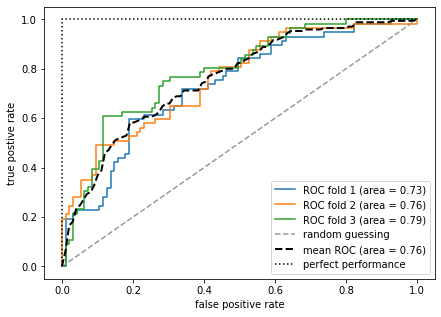

In [12]:
## Here we plot the different ROC Curves according to the different folds we have made in the dataset and then take the mean of these curves to plot the mean ROC Curve 
## Check the models accuracy
from sklearn.metrics import roc_curve,auc
from numpy import interp

pipe_lr = make_pipeline(StandardScaler(),PCA(n_components = 2),LogisticRegression(penalty = 'l2',random_state = 1,C = 100.0))
X_train2 = X_train[:,[4,14]]
cv = list(StratifiedKFold(n_splits = 3).split(X_train,y_train))
fig = plt.figure(figsize = (7,5))
mean_tpr = 0.0
mean_fpr = np.linspace(0,1,100)
all_tpr = []

for i,(train,test) in enumerate(cv):
    probas = pipe_lr.fit(X_train2[train],y_train[train]).predict_proba(X_train2[test])
    fpr , tpr,thresholds = roc_curve(y_train[test],probas[:,1],pos_label = 1)
    
    mean_tpr += interp(mean_fpr,fpr,tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr,tpr)
    plt.plot(fpr,tpr,label = 'ROC fold %d (area = %0.2f)' % (i+1,roc_auc))
    
plt.plot([0,1],[0,1],linestyle = '--',color = (0.6,0.6,0.6),label = 'random guessing')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr,mean_tpr)
plt.plot(mean_fpr,mean_tpr,'k--',label = 'mean ROC (area = %0.2f)' % mean_auc,lw = 2)

plt.plot([0,0,1],[0,1,1],linestyle = ':',color = 'black',label = 'perfect performance')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('false positive rate')
plt.ylabel('true postive rate')
plt.legend(loc = 'lower right')
plt.show()